In [1]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from utilities import *

In [2]:
X_train, X_test, y_train, y_test, pd_passthrough_train, pd_passthrough_test = prepare_data_4(data_subdir="ZMUMU_EGZ_extended_iso_vars",format_mode="iso_vars")

found preprepared data in ..\data\ZMUMU_EGZ_extended_iso_vars
[[12.175  0.    20.9    0.     0.     6.7  ]
 [21.425  0.    29.875  0.     0.     7.2  ]
 [ 9.45   0.    18.3    0.     0.8    8.85 ]
 ...
 [35.8    0.    35.8    0.     0.     0.   ]
 [ 9.175  8.75  15.125  4.475  5.225  6.575]
 [ 8.75   5.425 10.525  4.475  0.325  1.775]]


In [3]:
SVMs = ["rbf", "poly_2","poly_3","poly_4","linear","sigmoid"]
SGDs = ["hinge","log_loss","modified_huber","squared_hinge","perceptron"]
#SVMs = []
#SGDs = ["hinge"]

In [4]:
SVM_classifiers = []
SGD_classifiers = []

for SVM in SVMs:
    if SVM[0:4] == "poly":
        SVM_classifiers.append(SVC(kernel=SVM[0:4], C=1.0, degree=int(SVM[5]),  gamma='scale', random_state=42))
    else:
        SVM_classifiers.append(SVC(kernel=SVM, C=1.0, gamma='scale', random_state=42))

for SGD in SGDs:
    SGD_classifiers.append(SGDClassifier(loss=SGD, max_iter=10000, tol=1e-3, random_state=42, learning_rate="adaptive",eta0=0.1))

bdt_clf = XGBClassifier(random_state=42, tree_method='exact', learning_rate = 0.65)

In [5]:
SVM_predictions = []
SGD_predicitions = []

bdt_clf.fit(X_train, y_train)
y_pred_bdt = bdt_clf.predict(X_test)
pd_passthrough_test["pred_bdt"] = y_pred_bdt
evaluate_sklearn_model(y_test, y_pred_bdt, show_CR=False, show_MSE=False, model_name="bdt (isolation variables)")

for i, SGD_classifier in enumerate(SGD_classifiers):
    SGD_classifier.fit(X_train, y_train)
    y_pred_SGD = SGD_classifier.predict(X_test)
    SGD_predicitions.append(y_pred_SGD)
    pd_passthrough_test["pred_"+SGDs[i]] = y_pred_SGD
    evaluate_sklearn_model(y_test, y_pred_SGD, show_CR=False, show_MSE=False, model_name=SGDs[i]+" (isolation variables)")

for i, SVM_classifier in enumerate(SVM_classifiers):
    SVM_classifier.fit(X_train, y_train)
    y_pred_SVM = SVM_classifier.predict(X_test)
    SVM_predictions.append(y_pred_SVM)
    pd_passthrough_test["pred_"+SVMs[i]] = y_pred_SVM
    evaluate_sklearn_model(y_test, y_pred_SVM, show_CR=False, show_MSE=False, model_name=SVMs[i]+" (isolation variables)")

Evaluation of bdt (isolation variables)
Accuracy: 0.9600
Confusion Matrix:
 [[27342  1268]
 [  579 16993]]
Evaluation of hinge (isolation variables)
Accuracy: 0.9497
Confusion Matrix:
 [[26950  1660]
 [  661 16911]]
Evaluation of log_loss (isolation variables)
Accuracy: 0.9493
Confusion Matrix:
 [[27192  1418]
 [  922 16650]]
Evaluation of modified_huber (isolation variables)
Accuracy: 0.9499
Confusion Matrix:
 [[27182  1428]
 [  888 16684]]
Evaluation of squared_hinge (isolation variables)
Accuracy: 0.9485
Confusion Matrix:
 [[27205  1405]
 [  974 16598]]
Evaluation of perceptron (isolation variables)
Accuracy: 0.9370
Confusion Matrix:
 [[25858  2752]
 [  157 17415]]
Evaluation of rbf (isolation variables)
Accuracy: 0.9607
Confusion Matrix:
 [[27243  1367]
 [  448 17124]]
Evaluation of poly_2 (isolation variables)
Accuracy: 0.9516
Confusion Matrix:
 [[27506  1104]
 [ 1133 16439]]
Evaluation of poly_3 (isolation variables)
Accuracy: 0.9245
Confusion Matrix:
 [[27983   627]
 [ 2862 1471

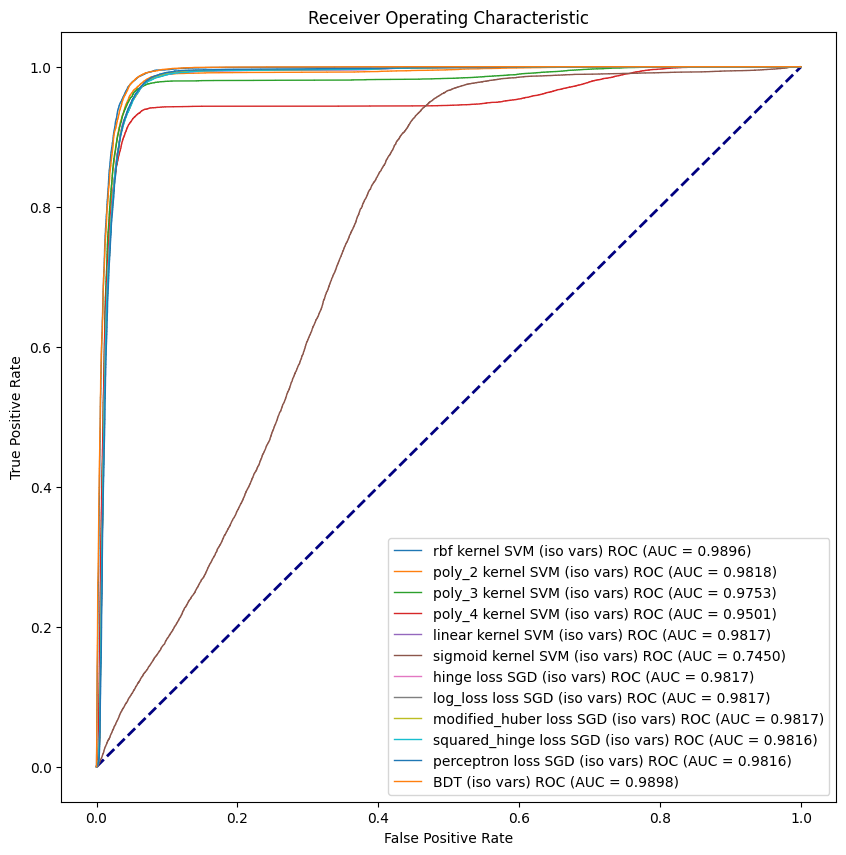

In [6]:
model_dict = {f"{SVMs[i]} kernel SVM "+"(iso vars)":SVM_classifiers[i] for i in range(len(SVMs))}
model_dict.update({f"{SGDs[i]} loss SGD "+"(iso vars)":SGD_classifiers[i] for i in range(len(SGDs))})
model_dict.update({"BDT "+"(iso vars)":bdt_clf})
multi_roc(model_dict,X_test,y_test)

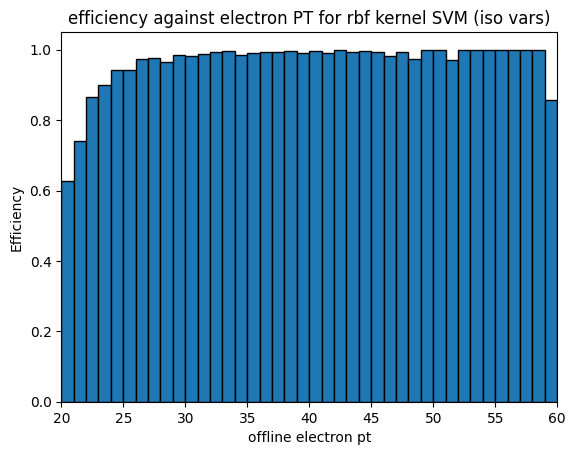

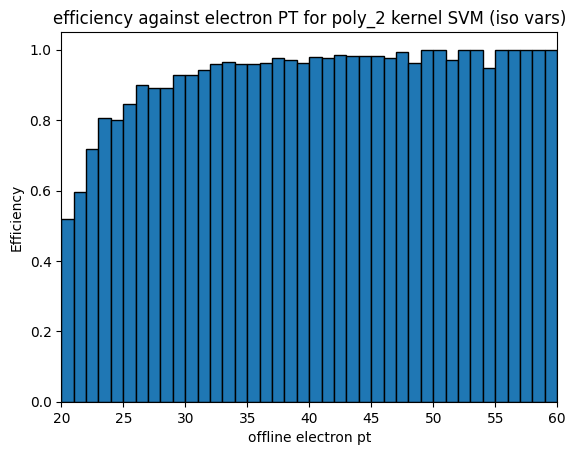

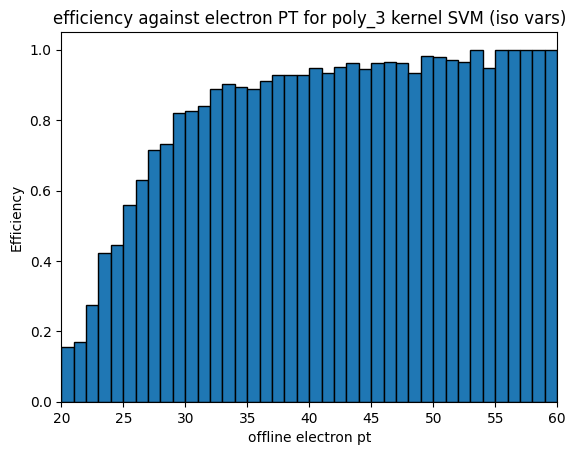

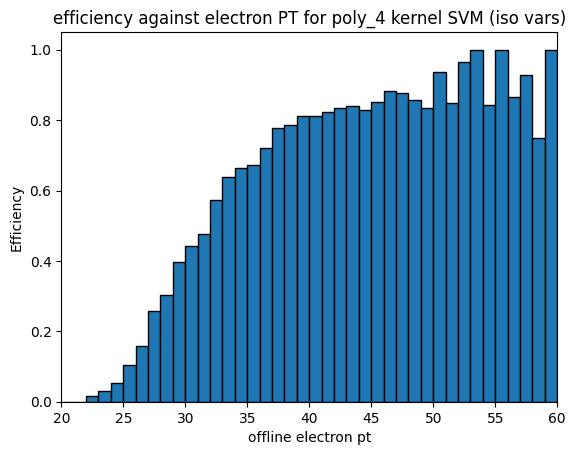

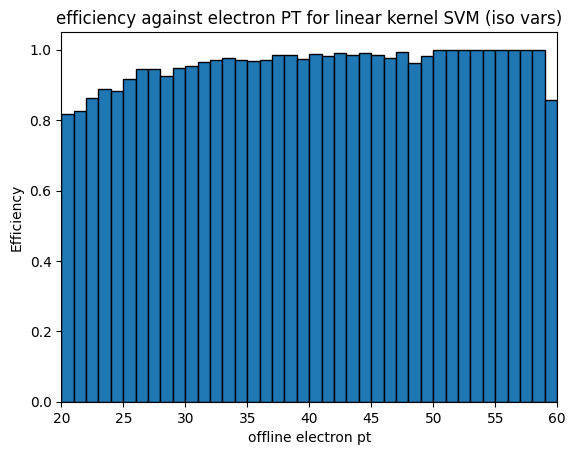

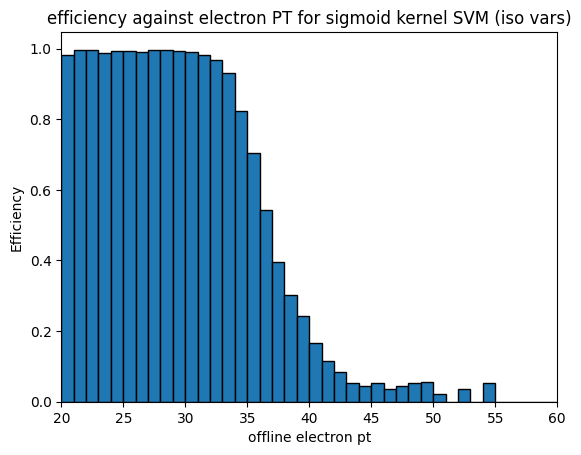

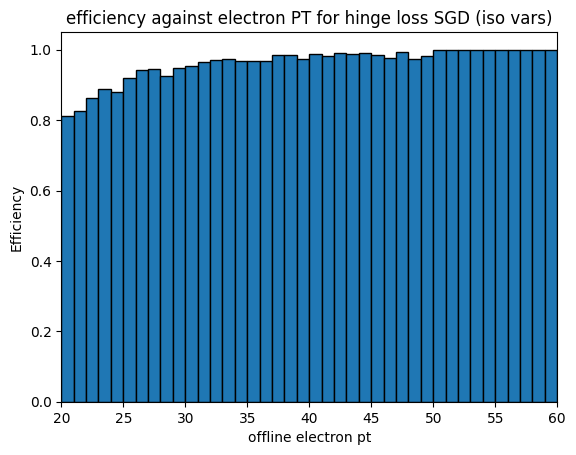

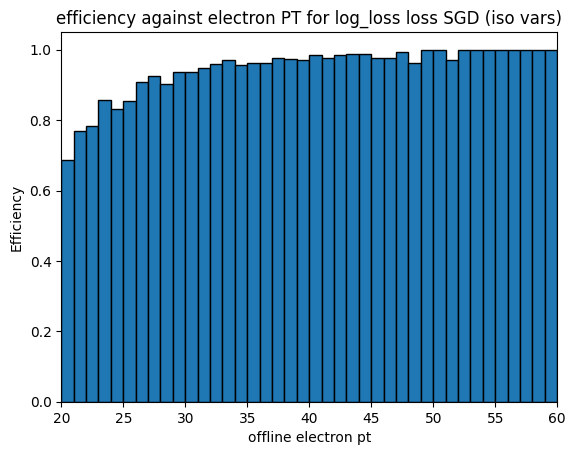

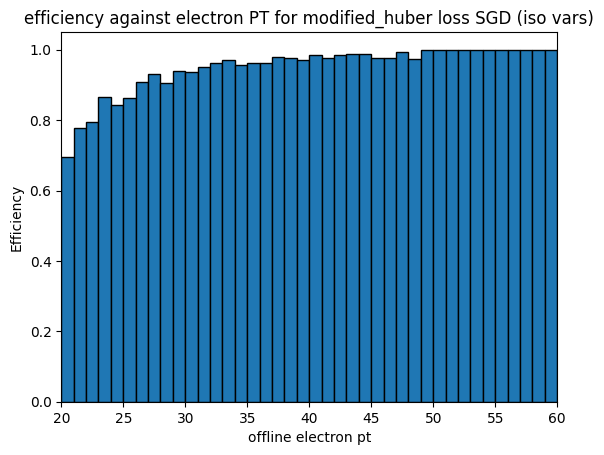

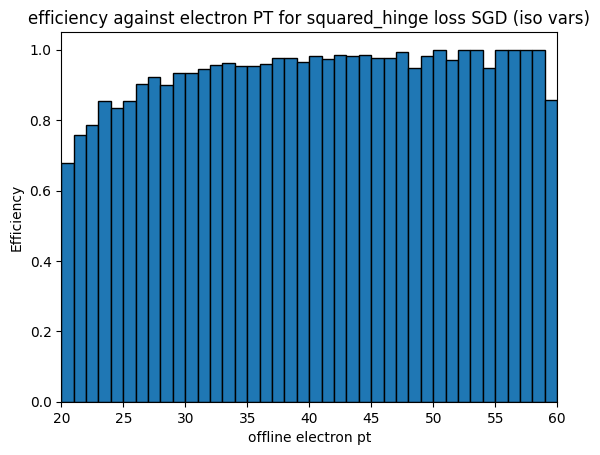

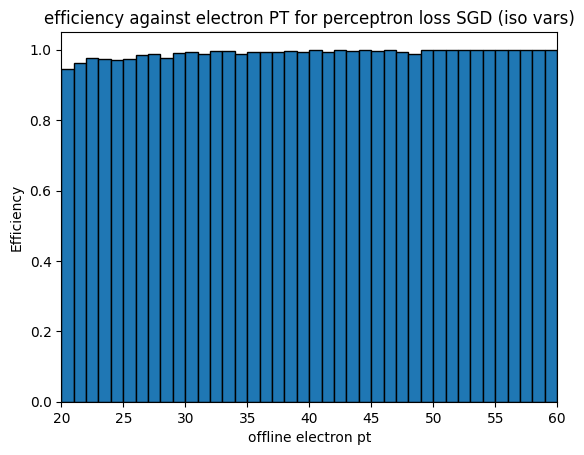

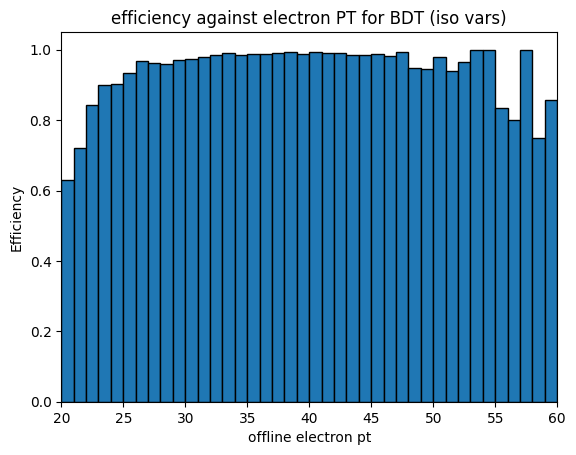

In [7]:
for i, SVM in enumerate(SVMs):
    plot_efficiency_vs_ele_PT(pd_passthrough_test, prediction_parameter="pred_"+SVMs[i], title_string=SVMs[i]+" kernel SVM "+"(iso vars)")
for i, SGD in enumerate(SGDs):
    plot_efficiency_vs_ele_PT(pd_passthrough_test, prediction_parameter="pred_"+SGDs[i], title_string=SGDs[i]+" loss SGD "+"(iso vars)")
plot_efficiency_vs_ele_PT(pd_passthrough_test, prediction_parameter="pred_bdt", title_string="BDT "+"(iso vars)")

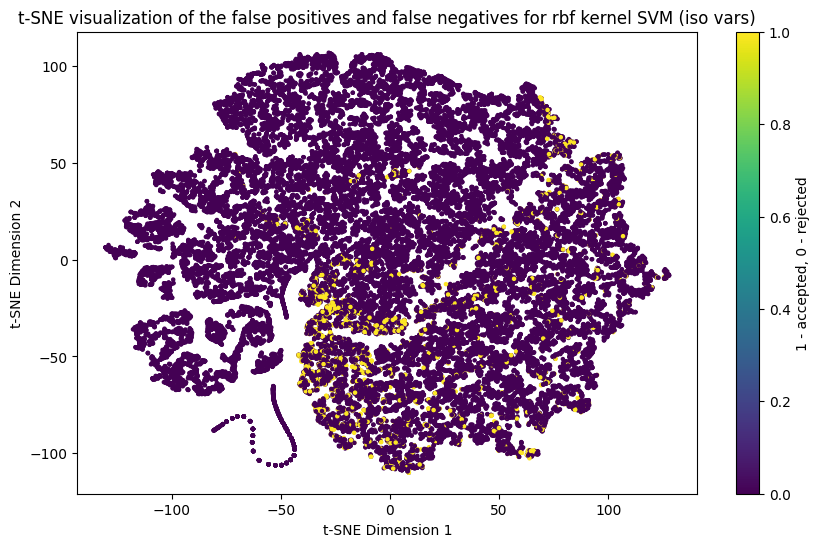

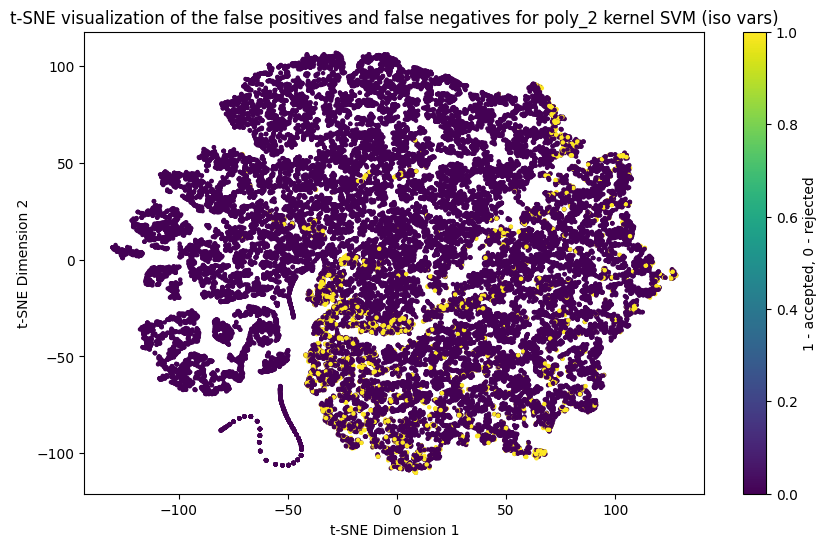

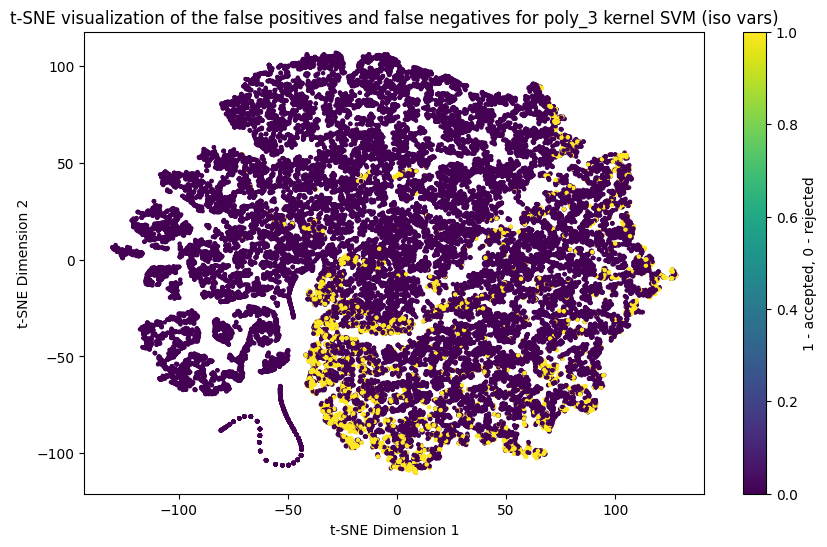

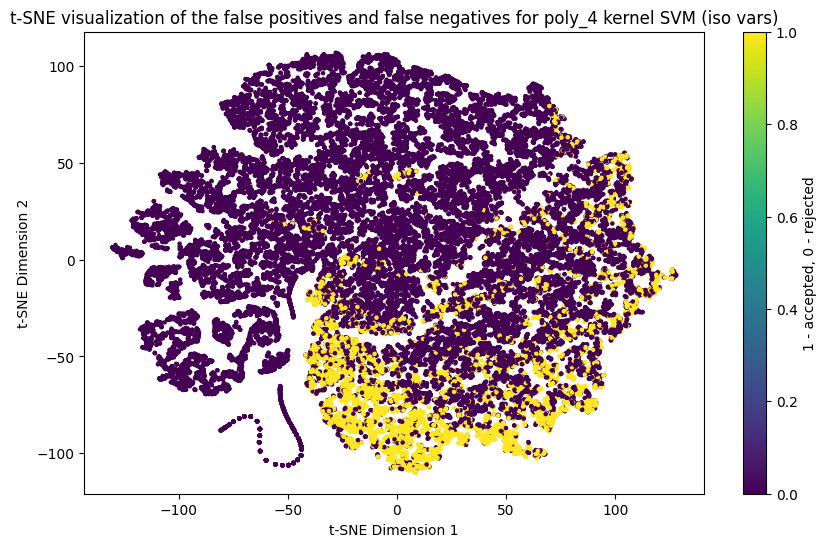

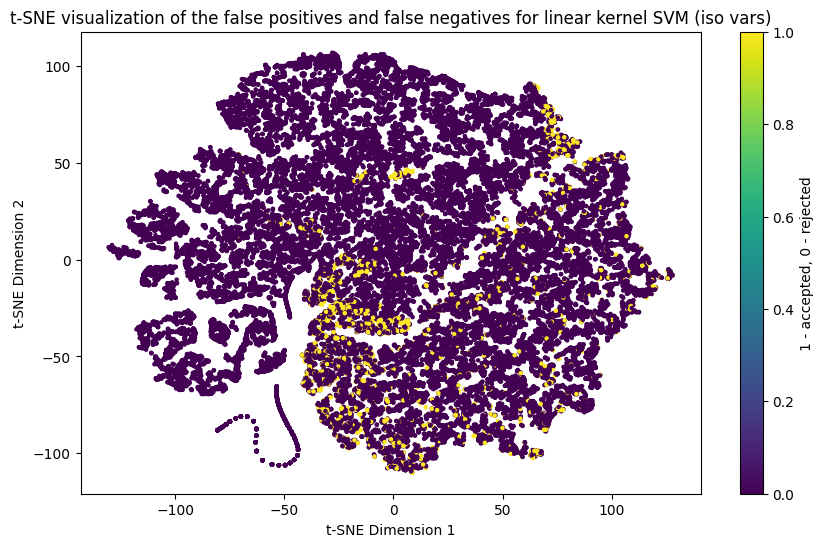

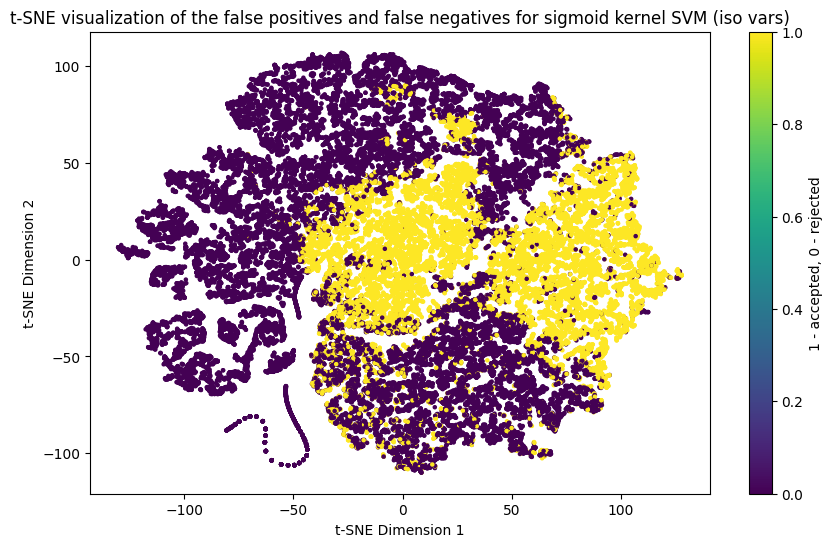

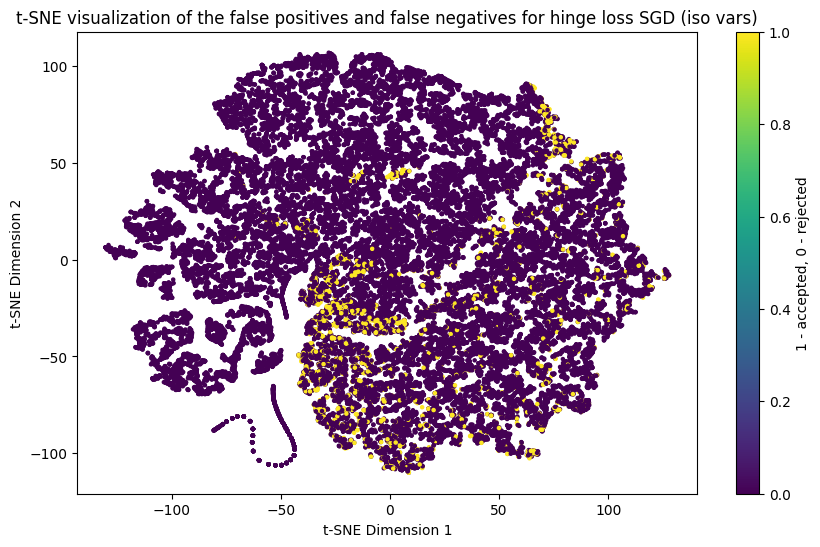

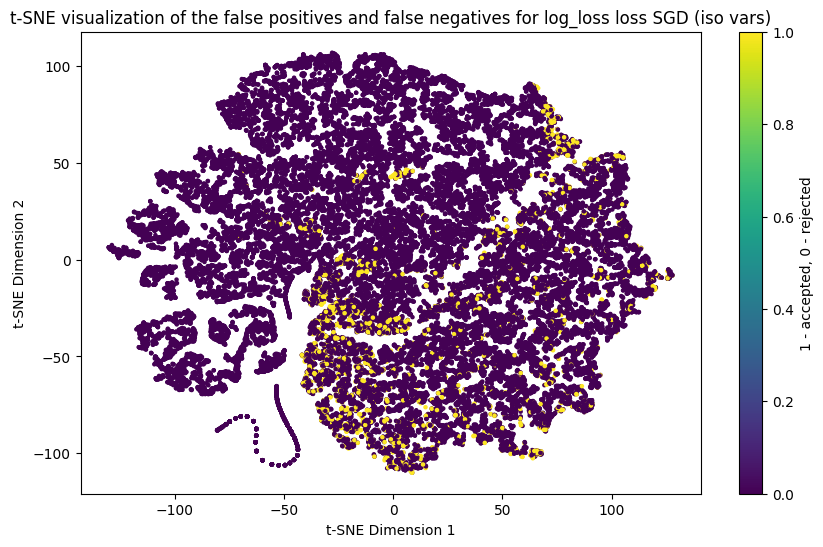

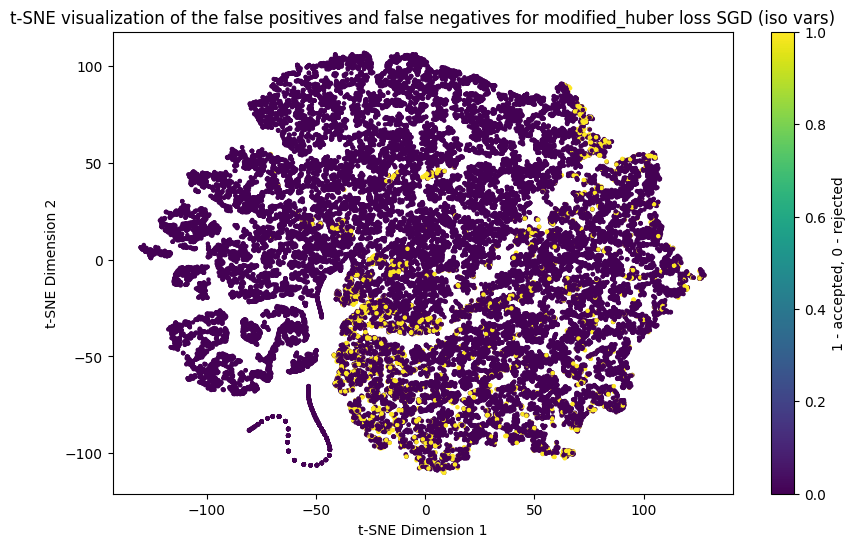

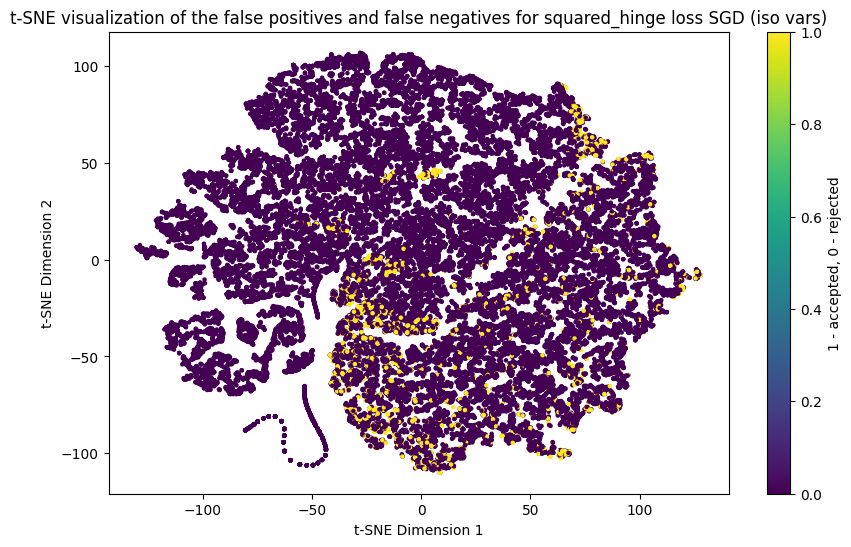

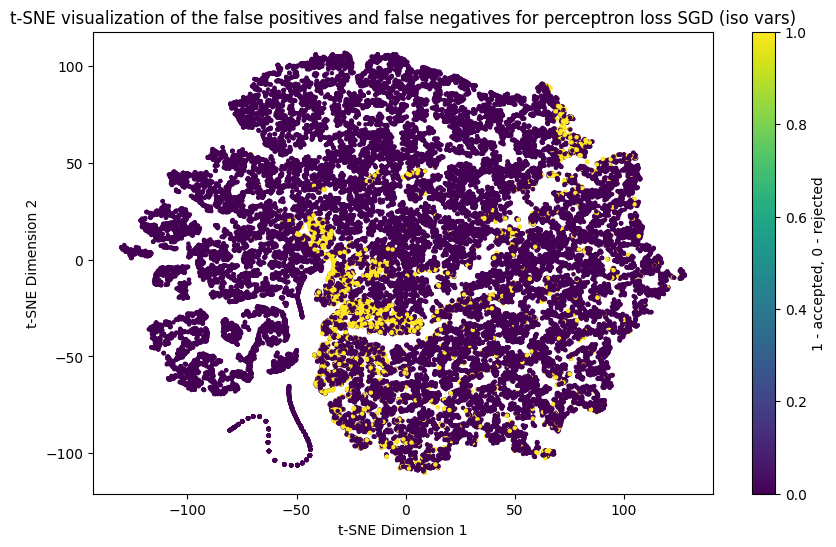

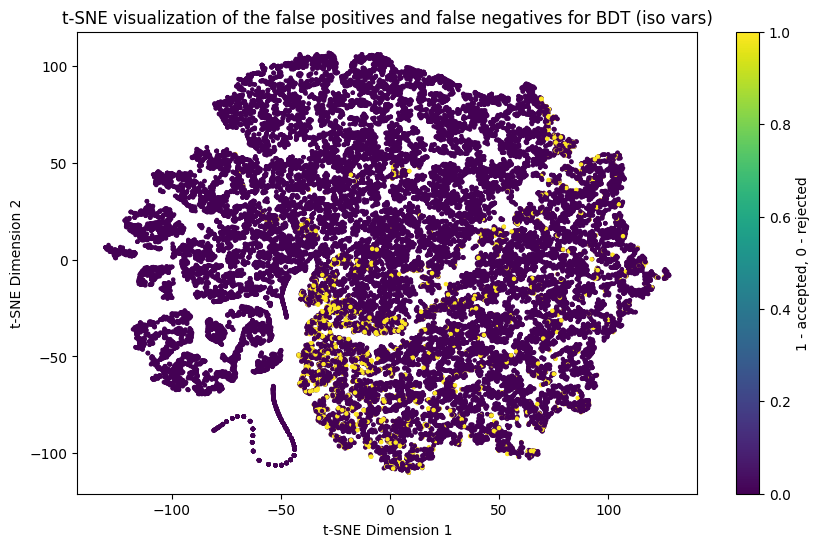

In [8]:
X_test_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_test) 

for i, SVM in enumerate(SVMs):
    y_fpfn = np.logical_xor(y_test, SVM_predictions[i])
    plot_2D_TSNE(X_test_embedded,y_fpfn,f"t-SNE visualization of the false positives and false negatives for {SVMs[i]} kernel SVM "+"(iso vars)")
for i, SGD in enumerate(SGDs):
    y_fpfn = np.logical_xor(y_test, SGD_predicitions[i])
    plot_2D_TSNE(X_test_embedded,y_fpfn,f"t-SNE visualization of the false positives and false negatives for {SGDs[i]} loss SGD "+"(iso vars)")


plot_2D_TSNE(X_test_embedded,np.logical_xor(y_test, y_pred_bdt),f"t-SNE visualization of the false positives and false negatives for BDT "+"(iso vars)")

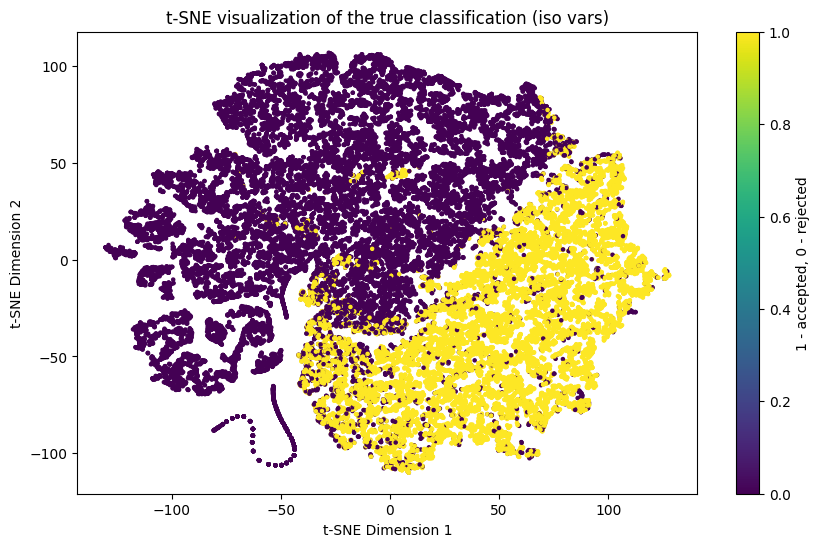

In [12]:
plot_2D_TSNE(X_test_embedded,y_test,f"t-SNE visualization of the true classification "+"(iso vars)")